# Load Dataset

In [1]:
import pandas as pd

df = pd.read_csv("data/data.csv")

# Remove nans
df = df.dropna(subset=["mean_cont_mos", "mean_vmaf", "mean_bitrate", "mean_psnr", "mean_ssim"])

# Input features and label

In [2]:
features = [
    "mean_vmaf", "mean_psnr", "mean_ssim",
    "mean_bitrate", "rebuffer_fraction"
]

X = df[features]
y = df["mean_cont_mos"]

# Split data

In [3]:
from sklearn.model_selection import train_test_split
videos = df["video_name"].unique()
train_videos, test_videos = train_test_split(videos, test_size=0.2, random_state=42)

train_df = df[df["video_name"].isin(train_videos)]
test_df = df[df["video_name"].isin(test_videos)]

X_train, Y_train = train_df[features], train_df["mean_cont_mos"]
X_test, Y_test = test_df[features], test_df["mean_cont_mos"]

# Train Regression Model (XGBoost)

In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"MSE: {mse:.4f}, R²: {r2:.4f}")

MSE: 0.2193, R²: 0.6522


# Feature Plotting

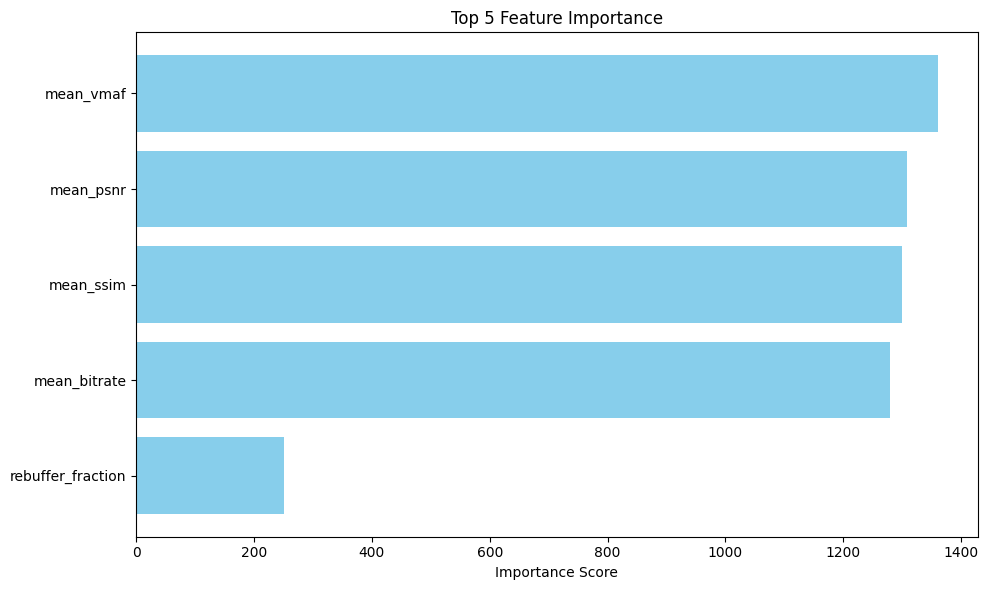

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

importance = model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

top_n = 5
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df['Feature'].head(top_n)[::-1],
    importance_df['Importance'].head(top_n)[::-1],
    color='skyblue'
)
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importance')
plt.tight_layout()
plt.show()

# Visualize predicted vs. true QoE

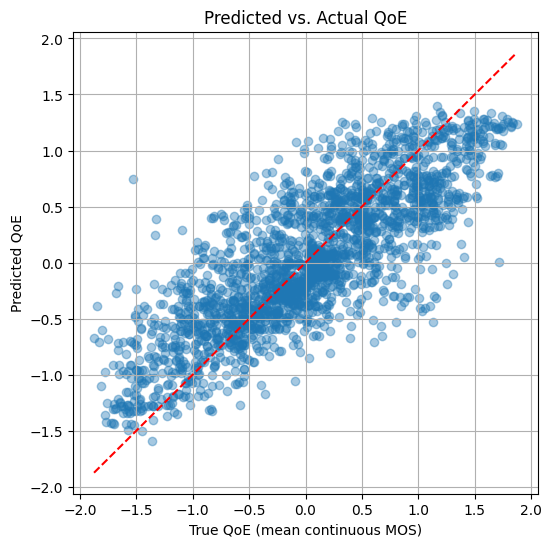

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(Y_test, y_pred, alpha=0.4)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  # perfect prediction line
plt.xlabel("True QoE (mean continuous MOS)")
plt.ylabel("Predicted QoE")
plt.title("Predicted vs. Actual QoE")
plt.grid(True)
plt.show()

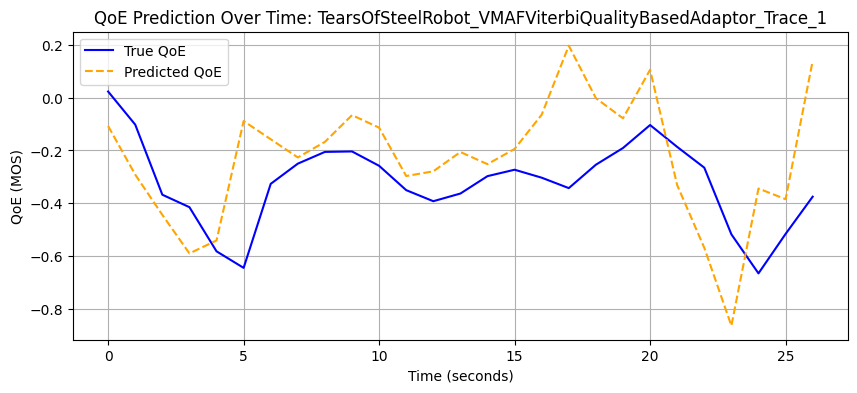

In [14]:
video = test_df["video_name"].iloc[0]
subset = test_df[test_df["video_name"] == video]
preds = model.predict(subset[features])

plt.figure(figsize=(10,4))
plt.plot(subset["second"], subset["mean_cont_mos"], label="True QoE", color="blue")
plt.plot(subset["second"], preds, label="Predicted QoE", color="orange", linestyle="--")
plt.xlabel("Time (seconds)")
plt.ylabel("QoE (MOS)")
plt.title(f"QoE Prediction Over Time: {video}")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import joblib

filename  = "models/qoe_model_xgb_v1.0.pkl"
joblib.dump(model, filename)
print(f"Model saved to {filename}")

Model saved to models/qoe_model_xgb_v1.0.pkl
